# FOOOFing EEG Data

This notebook runs through pre-processing and running FOOOF on EEG data.

It can be used to step through processing for individual subjects.

To run this procedure across the group, the script `process_eeg.py` should be used, which is available in the `scripts` folder.

In [1]:
%matplotlib inline

import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.signal import periodogram

# MNE & associated code
import mne
from mne.preprocessing import ICA, read_ica
from mne.utils import _time_mask

from autoreject import AutoReject, read_auto_reject
from autoreject.autoreject import _apply_interp

# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.objs import average_fg
from fooof.plts import plot_spectrum
from fooof.utils import trim_spectrum
from fooof.data import FOOOFSettings
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

## Settings

In [2]:
# Import custom code for this analysis
import sys
sys.path.append('../code')

from settings import DATA_PATH, RESULTS_PATH, BANDS

In [3]:
# Set subject index to load (as index from subjs_files)
sub_ind = 1

In [4]:
# Preprocessing options
#   If these are false - loads & applies saved solutions
run_ica = False
run_auto_reject = False
all_channels = True

In [5]:
# Set which average function to use
avg_func = np.mean
#avg_func = np.median

In [6]:
# Wether to save out plots or not
SAVE_FIG = False

## Data Loading

In [7]:
# Get list of subject files
subj_files = os.listdir(DATA_PATH)
subj_files = [file for file in subj_files if 'bdf' in file.lower()]
subj_files = sorted(subj_files)

In [8]:
# Get & check which subject is being run
subj_file = subj_files[sub_ind]
subj_label = subj_file.split('.')[0]

print(subj_label)

OA_052507-2_RAW


In [9]:
# Load data, and do things for fixing up the channel labels & types
eeg_dat = mne.io.read_raw_edf(os.path.join(DATA_PATH, subj_file), preload=True)

# Fix channel name labels
eeg_dat.info['ch_names'] = [chl[2:] for chl in eeg_dat.ch_names[:-1]] + [eeg_dat.ch_names[-1]]
for ind, chi in enumerate(eeg_dat.info['chs']):
    eeg_dat.info['chs'][ind]['ch_name'] = eeg_dat.info['ch_names'][ind]

# Set channel types
ch_types = {'LHor' : 'eog', 'RHor' : 'eog', 'IVer' : 'eog', 'SVer' : 'eog',
            'LMas' : 'misc', 'RMas' : 'misc', 'Nose' : 'misc', 'EXG8' : 'misc'}
eog_chs = ['LHor', 'RHor', 'IVer', 'SVer']

# Set channel types
eeg_dat.set_channel_types(ch_types)

Extracting EDF parameters from /Users/tom/Documents/Data/02-Shared/Voytek_WMData/G2/OA_052507-2_RAW.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1382399  =      0.000 ...  2699.998 secs...


<ipython-input-9-bf3686210480>:2: DeprecationWarning: The use of read_raw_edf for BDF files is deprecated. Please use read_raw_bdf instead.
  eeg_dat = mne.io.read_raw_edf(os.path.join(DATA_PATH, subj_file), preload=True)


In [10]:
# Keep current reference
#eeg_dat = eeg_dat.set_eeg_reference(ref_channels=[], projection=False, verbose=False)

# Set average reference
eeg_dat = eeg_dat.set_eeg_reference(ref_channels='average', projection=False, verbose=False)

# Set specific reference
#eeg_dat = eeg_dat.set_eeg_reference(['Cz'], projection=False)
#eeg_dat = eeg_dat.set_eeg_reference(['LMas', 'Rmas'], projection=False, verbose=False)

In [11]:
# Get sampling rate
srate = int(eeg_dat.info['sfreq'])

# Check if there are any channels marked bad
eeg_dat.info['bads']

[]

### Montage

In [12]:
# Set channel montage
chs = mne.channels.read_montage('standard_1020', eeg_dat.ch_names)
eeg_dat.set_montage(chs)

/opt/anaconda3/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-12-fd124d8dda94>:3: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_dig_polhe

<RawEDF  |  OA_052507-2_RAW.bdf, n_channels x n_times : 73 x 1382400 (2700.0 sec), ~770.1 MB, data loaded>

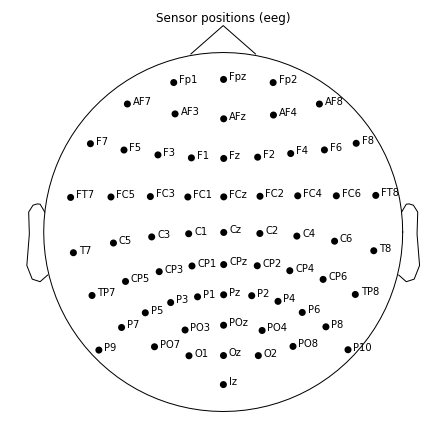

In [13]:
# Check channel positions
eeg_dat.plot_sensors(show_names=True);

In [14]:
# Define channel clusters
le_chs = ['P3', 'P5', 'P7', 'P9', 'O1', 'PO3', 'PO7']
ri_chs = ['P4', 'P6', 'P8', 'P10', 'O2', 'PO4', 'PO8']
le_picks = mne.pick_channels(eeg_dat.ch_names, le_chs)
ri_picks = mne.pick_channels(eeg_dat.ch_names, ri_chs)

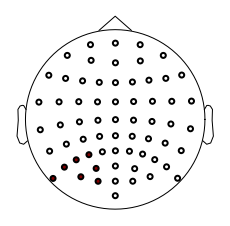

In [15]:
# Check channel positions
fig, ax = plt.subplots(figsize=[3, 3])
fig = eeg_dat.plot_sensors(show_names=False, title='', ch_groups=[[], le_picks], axes=ax);

if SAVE_FIG:
    plt.savefig('../figures/EEGHead.png', dpi=500)

### Pre-Processing: ICA

ICA is used to remove eye-related artifact. 

To do so, we do ICA on the data, and then use an MNE function that identifies ICA components to reject based on correlation with EOG channels. 

In [16]:
# High-pass filter for ICA
eeg_dat.filter(l_freq=1., h_freq=None, fir_design='firwin');

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)



In [17]:
if run_ica:
    
    # ICA settings
    method = 'fastica'

    #n_components = 20
    n_components = 0.99
    random_state = 48
    decim = None
    reject = {'eeg': 20e-4}

    # Initialize ICA object
    ica = ICA(n_components=n_components, method=method, random_state=random_state)
    
    # Fit ICA
    ica.fit(eeg_dat, decim=decim, reject=reject)

else:
    ica = read_ica(os.path.join(RESULTS_PATH, 'ICA', subj_label + '-ica.fif'))

Reading /Users/tom/Documents/Research/2-Projects/1-Current/fooof/2-Data/Results/ICA/OA_052507-2_RAW-ica.fif ...
Now restoring ICA solution ...
Ready.


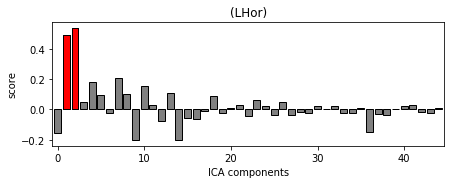

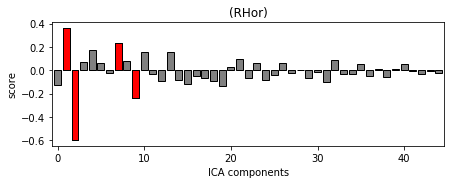

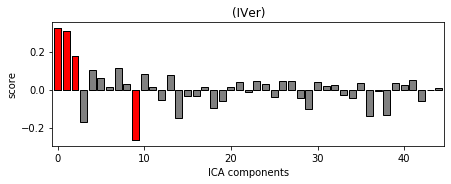

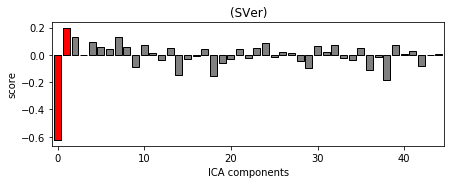

In [18]:
# Find components to drop, based on correlation with EOG channels
drop_inds = []
for chi in eog_chs:
    inds, scores = ica.find_bads_eog(eeg_dat, ch_name=chi, threshold=2.5,
                                     l_freq=1, h_freq=10, verbose=False)
    drop_inds.extend(inds)
    ica.plot_scores(scores, exclude=inds, labels=chi);
    
drop_inds = list(set(drop_inds))

In [19]:
# Check the set of components to be dropped
ica.exclude = drop_inds

print('Number of component to drop: \t', len(ica.exclude))
print('Dropped component indices: \t', ica.exclude)

Number of component to drop: 	 5
Dropped component indices: 	 [0, 1, 2, 7, 9]


In [20]:
# Save out the ICA solution
#ica.save('test-ica.fif')

# Note: can later load ICAs:
# from mne.preprocessing import read_ica
# ica = read_ica(ica_file)

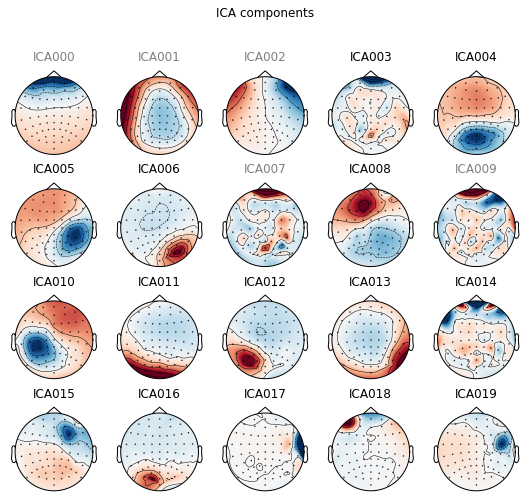

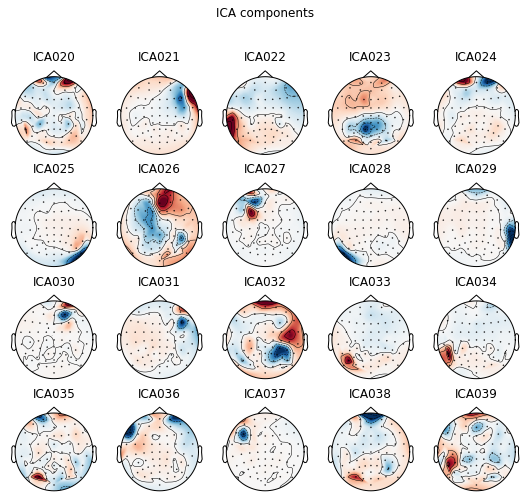

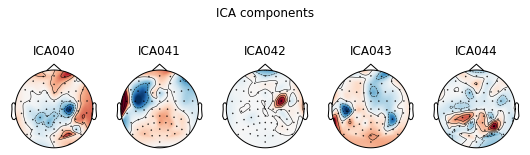

In [21]:
# Visualize the ICA components
ica.plot_components();

    Using multitaper spectrum estimation with 7 DPSS windows
1349 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
1349 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
1349 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
1349 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
1349 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


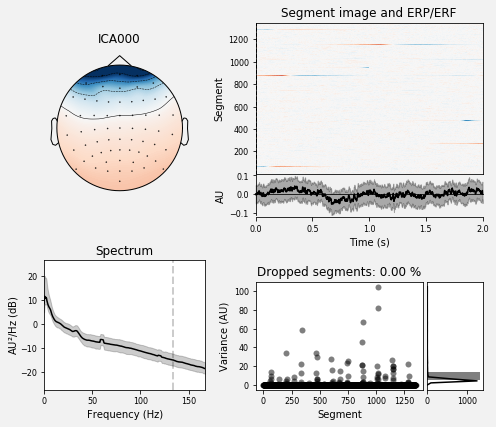

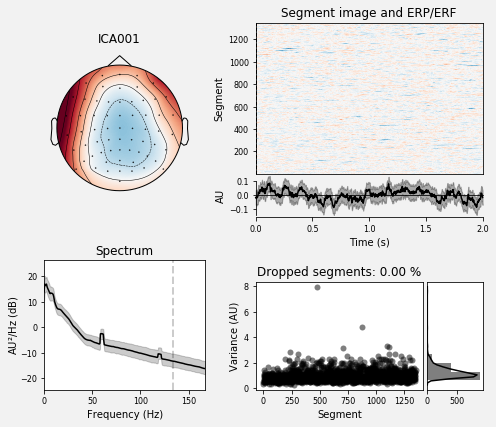

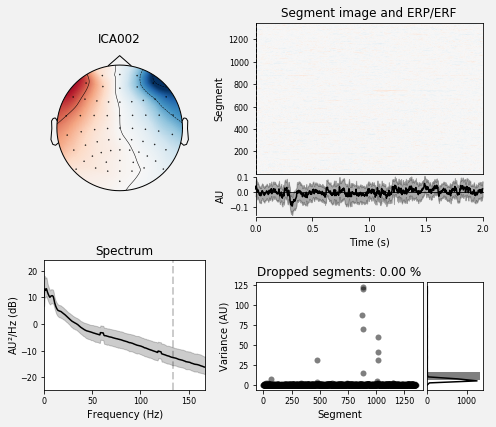

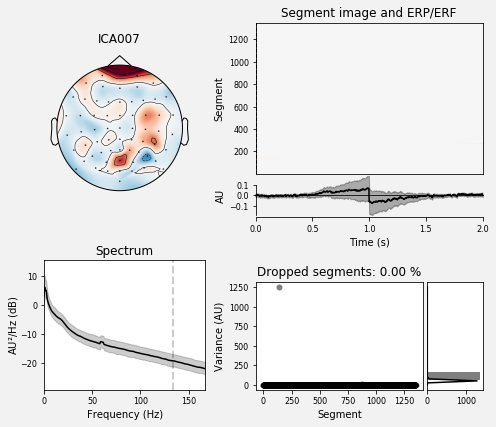

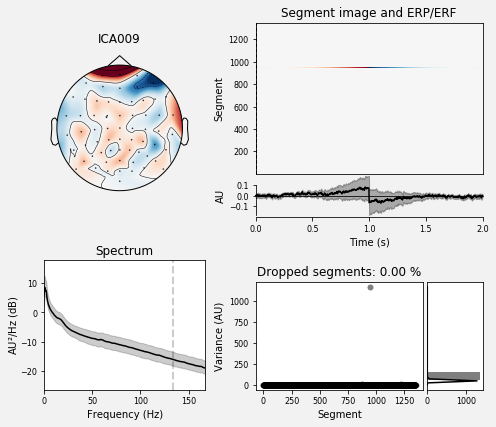

In [22]:
# Check description of the components that are marked to be dropped
ica.plot_properties(eeg_dat, picks=drop_inds);

Transforming to ICA space (45 components)
Zeroing out 5 ICA components


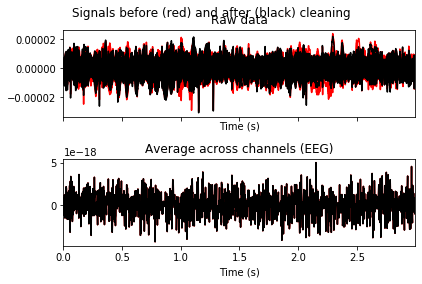

In [23]:
# Check the overlay of the data, with the components to be rejected
ica.plot_overlay(eeg_dat, exclude=drop_inds);

In [24]:
# Apply ICA to data
eeg_dat = ica.apply(eeg_dat);

Transforming to ICA space (45 components)
Zeroing out 5 ICA components


## Event management

In [25]:
# Get event information
evs = mne.find_events(eeg_dat, shortest_event=1, verbose=False)

# Check all used event codes
ev_codes = np.unique(evs[:, 2])

In [26]:
# Set up event code dictionary, with key labels for each event type
ev_dict = {'LeLo1': [201, 202], 'LeLo2': [205, 206], 'LeLo3': [209, 210], 
           'RiLo1': [203, 204], 'RiLo2': [207, 208], 'RiLo3': [211, 212]}

# Event codes for correct and incorrect codes
corr_codes = [2, 1]
inco_codes = [102, 101]

In [27]:
# Extract a list of all the event labels
all_trials = [it for it2 in ev_dict.values() for it in it2]

# Create list of new event codes to be used to label correct trials (300s)
all_trials_new = [it + 100 for it in all_trials]
# This is an annoying way to collapse across the doubled event markers from above
all_trials_new = [it - 1 if not ind % 2 == 0 else it \
                  for ind, it in enumerate(all_trials_new)]
# Get labelled dictionary of new event names
ev_dict2 = {k : v for k, v in zip(ev_dict.keys(), set(all_trials_new))}

In [28]:
# Initialize variables to store new event definitions
evs2 = np.empty(shape=[0, 3], dtype='int64')
lags = np.array([])

# Loop through, creating new events for all correct trials
t_min, t_max = -0.4, 3.0
for ref_id, targ_id, new_id in zip(all_trials, corr_codes * 6, all_trials_new):
    
    t_evs, t_lags = mne.event.define_target_events(evs, ref_id, targ_id, srate, t_min, t_max, new_id)
    
    if len(t_evs) > 0:
        evs2 = np.vstack([evs2, t_evs])
        lags = np.concatenate([lags, t_lags])
        
# Sort event codes
evs2 = np.sort(evs2, 0)

In [29]:
# Check how many of each event type there are
print(Counter(evs[:, 2]))
print('\n')
print(Counter(evs2[:, 2]))

Counter({55: 800, 1: 393, 2: 374, 202: 70, 207: 70, 205: 70, 208: 70, 203: 70, 209: 70, 204: 70, 206: 70, 210: 60, 212: 60, 201: 60, 211: 60, 101: 25, 65536: 9, 102: 6, 11: 3})


Counter({303: 137, 307: 136, 305: 132, 301: 129, 309: 120, 311: 113})


### Check Data

In [30]:
# Set channel of interest
ch_ind = eeg_dat.ch_names.index('Oz')

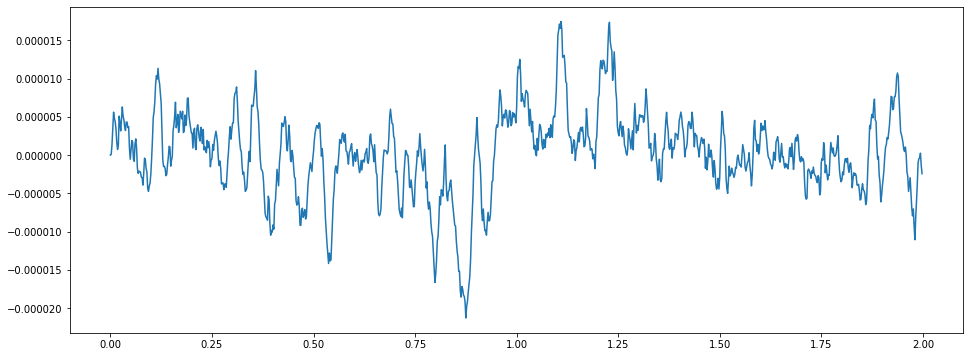

In [31]:
# Plot a segment of data - to eyeball
start = 0 # Index to start plotting at, in samples
inds = [start, start + 2*srate]  # 2 seconds of data
fig = plt.figure(figsize=[16, 6])
plt.plot(eeg_dat.times[inds[0]:inds[1]], eeg_dat._data[ch_ind, inds[0]:inds[1]])

In [32]:
# PSD settings
n_fft, n_overlap, n_per_seg = int(2*srate), int(srate), int(2*srate)

# Data settings
fmin, fmax = (1, 50)
tmin, tmax = (5, 125)

# Calculate PSDs (across all channels) - from the first 2 minute of data
psds, freqs = mne.time_frequency.psd_welch(
    eeg_dat, fmin=fmin, fmax=fmax, tmin=tmin ,tmax=tmax,
    n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg, verbose=False)

### Individualized Alpha Peak

In [33]:
# Get individual power spectrum of interest
cur_psd = psds[ch_ind, :]

In [34]:
# Get the peak within the alpha range
al_freqs, al_psd = trim_spectrum(freqs, cur_psd, [7, 14])
icf_ind = np.argmax(al_psd)
al_icf = al_freqs[icf_ind]

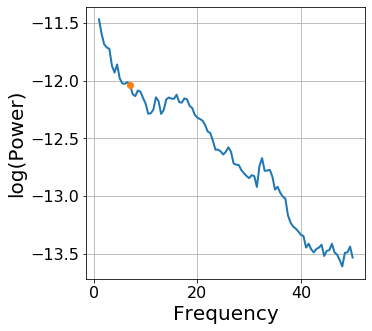

In [35]:
# Plot the power spectrum, with the individually detected alpha peak
plot_spectrum(freqs, cur_psd, log_powers=True, ax=plt.subplots(figsize=(5, 5))[1])
plt.plot(al_icf, np.log10(al_psd[icf_ind]), '.', markersize=12)

### FOOOF 

In [36]:
# Initialize FOOOFGroup object
f_range = [3, 25]
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6,
                min_peak_height=0.05, peak_threshold=1.5)

# Run FOOOF across all power spectra
fg.fit(freqs, psds, f_range, n_jobs=-1)

Running FOOOFGroup across 64 power spectra.


                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.3581, 0.8641                                         
                                                                                                  
                                       5 peaks were found:                                        
          

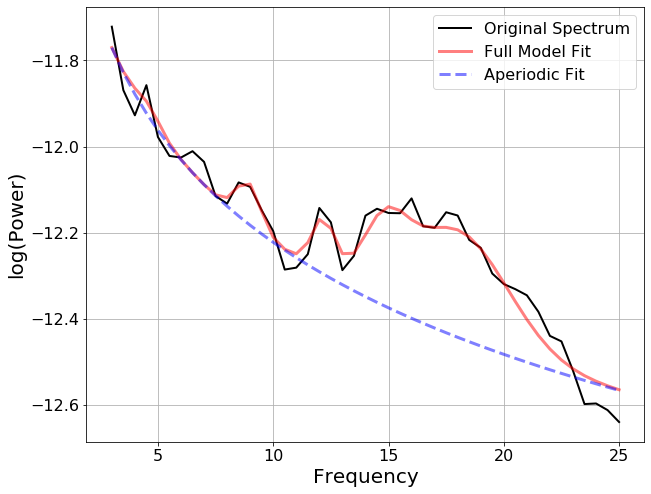

In [37]:
# Check FOOOF model fit of particular channel of interest
fm = fg.get_fooof(ch_ind, True)
fm.print_results()
fm.plot()

In [38]:
# Extract individualized CF from channel Oz
fooof_freq, _, fooof_bw = get_band_peak_fm(fm, BANDS.alpha)

# If not FOOOF alpha extracted, reset to 10
if np.isnan(fooof_freq):
    fooof_freq = 10

In [39]:
# Compare peak-find alpha peak to fooof alpha peak
print('IndiPeak CF: \t{:0.2f}'.format(al_icf))
print('FOOOF    CF: \t{:0.2f}'.format(fooof_freq))

IndiPeak CF: 	7.00
FOOOF    CF: 	12.18


In [40]:
# Check extracted FOOOF alpha properties
print('Alpha CF: \t{:0.2f}'.format(fooof_freq))
print('Alpha BW: \t{:0.2f}'.format(fooof_bw))

Alpha CF: 	12.18
Alpha BW: 	1.00


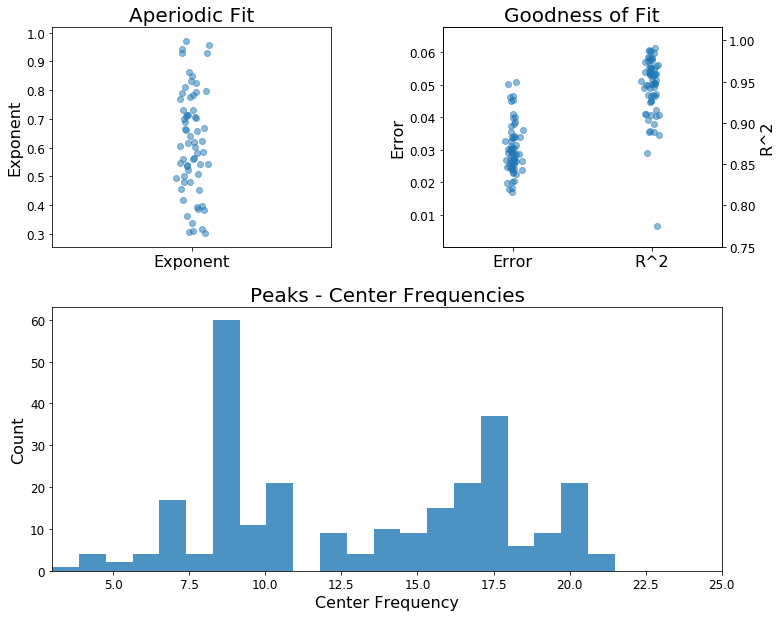

In [41]:
# Check a summary of the FOOOFGroup results across all channels
fg.plot()

In [42]:
# Extract some FOOOF data across all electrodes

# Extract exponents - all channels
all_exps = fg.get_params('aperiodic_params', 'exponent')

# Extract alpha oscillations - all channels
alphas = get_band_peak_fg(fg, BANDS.alpha)

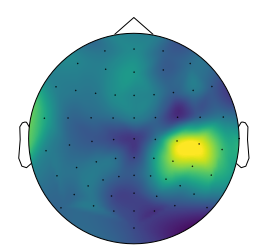

In [43]:
# Plot alpha topography
dat_ind = 1 # 0:CF; 1:PW; 2:BW

# For sake of visualization, replace any NaN with the mean
temp_dat = alphas[:, dat_ind]
inds = np.where(np.isnan(temp_dat))
temp_dat[inds] = np.nanmean(temp_dat)

mne.viz.plot_topomap(temp_dat, eeg_dat.info, cmap=cm.viridis, contours=0);

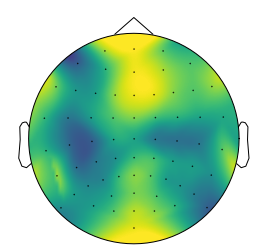

In [44]:
# Plot exponent topography
mne.viz.plot_topomap(all_exps, eeg_dat.info, cmap=cm.viridis, contours=0);

## Filtering & Envelope

#### Canonical Alpha Range

In [45]:
# Filter data to canonical alpha band: 8-12 Hz
alpha_dat = eeg_dat.copy()
alpha_dat.filter(8, 12, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 sec)



<RawEDF  |  OA_052507-2_RAW.bdf, n_channels x n_times : 73 x 1382400 (2700.0 sec), ~770.1 MB, data loaded>

#### FOOOF defined subject-specific alpha band

In [46]:
# Filter data to FOOOF derived alpha band
fooof_dat = eeg_dat.copy()
fooof_dat.filter(fooof_freq-2, fooof_freq+2, fir_design='firwin')

#filt_bw = fooof_bw * 1.5
#fooof_dat.filter(fooof_freq-filt_bw, fooof_freq+filt_bw, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 10 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.18
- Lower transition bandwidth: 2.54 Hz (-6 dB cutoff frequency: 8.90 Hz)
- Upper passband edge: 14.18 Hz
- Upper transition bandwidth: 3.54 Hz (-6 dB cutoff frequency: 15.95 Hz)
- Filter length: 665 samples (1.299 sec)



<RawEDF  |  OA_052507-2_RAW.bdf, n_channels x n_times : 73 x 1382400 (2700.0 sec), ~770.1 MB, data loaded>

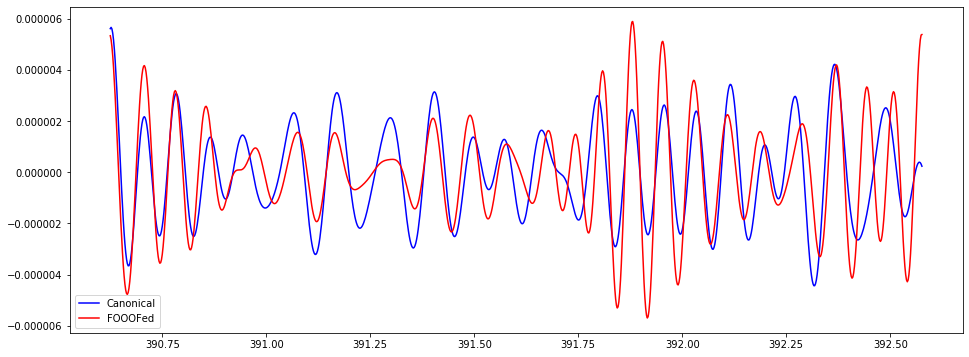

In [47]:
# Plot the differently filtered traces - check for differences
inds = [200000, 201000] # Arbitrary time points
fig = plt.figure(figsize=[16, 6])
plt.plot(alpha_dat.times[inds[0]:inds[1]], alpha_dat._data[ch_ind, inds[0]:inds[1]], 'b', label='Canonical')
plt.plot(fooof_dat.times[inds[0]:inds[1]], fooof_dat._data[ch_ind, inds[0]:inds[1]], 'r', label='FOOOFed')
plt.legend()

In [48]:
# Take the analytic amplitude (hilbert) of the alpha-filtered signals
alpha_dat.apply_hilbert(envelope=True)
fooof_dat.apply_hilbert(envelope=True)

<RawEDF  |  OA_052507-2_RAW.bdf, n_channels x n_times : 73 x 1382400 (2700.0 sec), ~770.1 MB, data loaded>

### Epoching

In [49]:
# Epoch settings
#tmin, tmax = -0.5, 1.2
tmin, tmax = -0.85, 1.1

# Epoch trials - raw data for trial rejection
#epochs = mne.Epochs(eeg_dat, evs2, ev_dict2, tmin=tmin, tmax=tmax, baseline=(-0.5, -0.35), preload=True)
epochs = mne.Epochs(eeg_dat, evs2, ev_dict2,
                    tmin=tmin, tmax=tmax,
                    baseline=None, preload=True)

# Epoch trials - filtered version
epochs_alpha = mne.Epochs(alpha_dat, evs2, ev_dict2,
                          tmin=tmin, tmax=tmax,
                          baseline=(-0.50, -0.35), preload=True);
epochs_fooof = mne.Epochs(fooof_dat, evs2, ev_dict2,
                          tmin=tmin, tmax=tmax,
                          baseline=(-0.50, -0.35), preload=True);

767 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 767 events and 999 original time points ...
0 bad epochs dropped
767 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 767 events and 999 original time points ...
0 bad epochs dropped
767 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 767 events and 999 original time points ...
0 bad epochs dropped


### Pre-Processing: Autoreject

In [52]:
read_auto_reject??

In [50]:
if run_auto_reject:
    
    # Initialize & fit autoreject
    ar = AutoReject(n_jobs=4, verbose=False)
    ar.fit(epochs)

else:
    ar = read_auto_reject(os.path.join(RESULTS_PATH, 'AR', subj_label + '-ar.hdf5'))
    ar.verbose = 'tqdm_notebook'

KeyError: 'dots'

In [ ]:
# Save out the autoreject solution
#ar.save('test-ar.hdf5', overwrite=True)

# Note: can later load ARs
# from autoreject import read_auto_reject
# ar = read_auto_reject(ar_file)

In [ ]:
# Apply autoreject to the original epochs object it was learnt on
epochs, rej_log = ar.transform(epochs, return_log=True)

In [ ]:
# Apply autoreject to the copies of the data - apply interpolation, then drop same epochs
_apply_interp(rej_log, epochs_alpha, ar.threshes_, ar.picks_, ar.verbose)
epochs_alpha.drop(rej_log.bad_epochs)
_apply_interp(rej_log, epochs_fooof, ar.threshes_, ar.picks_, ar.verbose)
epochs_fooof.drop(rej_log.bad_epochs)

In [ ]:
# Check which epochs were dropped
drop_inds = np.where(rej_log.bad_epochs)[0]
print(drop_inds)

### Set channel clusters

In [ ]:
# Replot channel positions
eeg_dat.plot_sensors(show_names=True);

In [ ]:
# Set channel clusters for analysis - take channels contralateral to stimulus presentation
le_chs = ['P3', 'P5', 'P7', 'P9', 'O1', 'PO3', 'PO7']
le_inds = [epochs.ch_names.index(chn) for chn in le_chs]
ri_chs = ['P4', 'P6', 'P8', 'P10', 'O2', 'PO4', 'PO8']
ri_inds = [epochs.ch_names.index(chn) for chn in ri_chs]

### Trial-Related Analysis

In [ ]:
# Check lateralized alpha response for particular trial type
trial_type = 'RiLo3'
times = np.arange(tmin, tmax, 1/srate)
plt.figure(figsize=[12, 8])
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T[:, 0], label=trial_type+'-LeftChs')
plt.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T[:, 0], label=trial_type+'-RightChs')
plt.legend();

In [ ]:
# Plot the responses across channels
trial_type = 'LeLo3'
times = np.arange(tmin, tmax, 1/srate)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[16, 6])

ax1.plot(times, np.mean(epochs_alpha[trial_type]._data[:, le_inds, :], 0).T);
ax1.set_title(trial_type+'-Left Chs')
ax1.legend(le_chs);

ax2.plot(times, np.mean(epochs_alpha[trial_type]._data[:, ri_inds, :], 0).T);
ax2.set_title(trial_type+'-Right Chs')
ax2.legend(ri_chs);

In [ ]:
# Pull out channel of interest for each load level - canonical data
#  Channels extracted are those contralateral to stimulus presentation
lo1_a = np.concatenate([epochs_alpha['LeLo1']._data[:, ri_inds, :], epochs_alpha['RiLo1']._data[:, le_inds, :]], 0)
lo2_a = np.concatenate([epochs_alpha['LeLo2']._data[:, ri_inds, :], epochs_alpha['RiLo2']._data[:, le_inds, :]], 0)
lo3_a = np.concatenate([epochs_alpha['LeLo3']._data[:, ri_inds, :], epochs_alpha['RiLo3']._data[:, le_inds, :]], 0)

In [ ]:
# Pull out channel of interest for each load level - fooofed data
#  Channels extracted are those contralateral to stimulus presentation
lo1_f = np.concatenate([epochs_fooof['LeLo1']._data[:, ri_inds, :], epochs_fooof['RiLo1']._data[:, le_inds, :]], 0)
lo2_f = np.concatenate([epochs_fooof['LeLo2']._data[:, ri_inds, :], epochs_fooof['RiLo2']._data[:, le_inds, :]], 0)
lo3_f = np.concatenate([epochs_fooof['LeLo3']._data[:, ri_inds, :], epochs_fooof['RiLo3']._data[:, le_inds, :]], 0)

In [ ]:
# Calculate average across trials and channels
lo1_a_avg = np.mean(lo1_a, 1).mean(0)
lo2_a_avg = np.mean(lo2_a, 1).mean(0)
lo3_a_avg = np.mean(lo3_a, 1).mean(0)
canonical_avg = np.vstack([lo1_a_avg, lo2_a_avg, lo3_a_avg])

# Calculate average across trials and channels
lo1_f_avg = np.mean(lo1_f, 1).mean(0)
lo2_f_avg = np.mean(lo2_f, 1).mean(0)
lo3_f_avg = np.mean(lo3_f, 1).mean(0)
fooofed_avg = np.vstack([lo1_f_avg, lo2_f_avg, lo3_f_avg])

In [ ]:
# Plot alpha response between different alpha filters
#plot_alpha_response_compare(canonical_avg, fooofed_avg, [tmin, tmax], srate)

## FOOOFING TRIAL AVERAGED DATA

In [ ]:
# Set labels
load_labels = ['Load1', 'Load2', 'Load3']
side_labels = ['Contra', 'Ipsi']
seg_labels = ['Pre', 'Early', 'Late']

# Set up the dictionary to store all the FOOOF results
fm_dict = dict()
for load_label in load_labels:
    fm_dict[load_label] = dict()
    for side_label in side_labels:
        fm_dict[load_label][side_label] = dict()
        for seg_label in seg_labels:
            fm_dict[load_label][side_label][seg_label] = []

In [ ]:
# Eyeball fm_dict works
fm_dict

In [ ]:
# Settings for trial averaged FOOOFing
fmin, fmax = 3, 25
n_fft, n_overlap, n_per_seg = 4*srate, srate/4, srate
seg_times = [(-0.85, -0.35), (0.1, 0.6), (0.5, 1.0)]

In [ ]:
# Initialize FOOOF objects
fooof_settings = FOOOFSettings(peak_width_limits=[1, 6], max_n_peaks=6,
                               min_peak_height=0.05, peak_threshold=1.5,
                               aperiodic_mode='fixed')
fm = FOOOF(*fooof_settings, verbose=False)
fg = FOOOFGroup(*fooof_settings, verbose=False)

In [ ]:
# Loop through loads
for seg_label, seg_time in zip(seg_labels, seg_times):
    tmin, tmax = seg_time[0], seg_time[1]

    for le_label, ri_label, load_label in zip(['LeLo1', 'LeLo2', 'LeLo3'],
                                              ['RiLo1', 'RiLo2', 'RiLo3'], 
                                              load_labels):
        
        ## Calculate trial wise PSDs for left & right side trials
        # Note: psds arrays have shape [n_trials , n_channels, n_freqs]
        trial_freqs, le_trial_psds = periodogram(
            epochs[le_label]._data[:, :, _time_mask(epochs.times, tmin, tmax, srate)],
            srate, window='hann', nfft=4*srate)
        trial_freqs, ri_trial_psds = periodogram(
            epochs[ri_label]._data[:, :, _time_mask(epochs.times, tmin, tmax, srate)],
            srate, window='hann', nfft=4*srate)
        
        ## FIT ALL CHANNELS VERSION
        if all_channels:
    
            ## Average spectra across trials within a given load & side
            le_avg_psd_contra = avg_func(le_trial_psds[:, ri_inds, :], 0)
            le_avg_psd_ipsi = avg_func(le_trial_psds[:, le_inds, :], 0)
            ri_avg_psd_contra = avg_func(ri_trial_psds[:, le_inds, :], 0)
            ri_avg_psd_ipsi = avg_func(ri_trial_psds[:, ri_inds, :], 0)

            ## Combine spectra across left & right trials for given load
            ch_psd_contra = np.vstack([le_avg_psd_contra, ri_avg_psd_contra])
            ch_psd_ipsi = np.vstack([le_avg_psd_ipsi, ri_avg_psd_ipsi])

            ## Fit FOOOFGroup to all channels, average & and collect results
            fg.fit(trial_freqs, ch_psd_contra, [fmin, fmax])
            fm = average_fg(fg, BANDS)
            fm_dict[load_label]['Contra'][seg_label] = fm.copy()
            fg.fit(trial_freqs, ch_psd_ipsi, [fmin, fmax])
            fm = average_fg(fg, BANDS)
            fm_dict[load_label]['Ipsi'][seg_label] = fm.copy()
        
        ## COLLAPSE ACROSS CHANNELS VERSION 
        else:
        
            ## Average spectra across trials and channels within a given load & side
            le_avg_psd_contra = avg_func(avg_func(le_trial_psds[:, ri_inds, :], 0), 0)
            le_avg_psd_ipsi = avg_func(avg_func(le_trial_psds[:, le_inds, :], 0), 0)
            ri_avg_psd_contra = avg_func(avg_func(ri_trial_psds[:, le_inds, :], 0), 0)
            ri_avg_psd_ipsi = avg_func(avg_func(ri_trial_psds[:, ri_inds, :], 0), 0)

            ## Collapse spectra across left & right trials for given load
            avg_psd_contra = avg_func(np.vstack([le_avg_psd_contra, ri_avg_psd_contra]), 0)
            avg_psd_ipsi = avg_func(np.vstack([le_avg_psd_ipsi, ri_avg_psd_ipsi]), 0)

            ## Fit FOOOF, and collect results
            fm.fit(trial_freqs, avg_psd_contra, [fmin, fmax])
            fm_dict[load_label]['Contra'][seg_label] = fm.copy()
            fm.fit(trial_freqs, avg_psd_ipsi, [fmin, fmax])
            fm_dict[load_label]['Ipsi'][seg_label] = fm.copy()

In [ ]:
# Print & plot trial average results
cur_load = 'Load3'
for fm in fm_dict[cur_load]['Contra'].values():
    fm.print_results()

In [ ]:
fm_dict['Load1']['Contra']['Pre'].print_results()

## Create an example FOOOF model fit plot

In [ ]:
# Grab an individual FOOOF model fit
pfm = fg.get_fooof(11, True)

In [ ]:
# Define a helper function to style the model fit
def plot_style(ax, xlog, ylog):
    
    ax.grid(True)

    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    for line in ax.get_lines():
        line.set_linewidth(3)

    [b.set_linewidth(2) for a, b in ax.spines.items()];

In [ ]:
# Create the model fit plot
fig, ax = plt.subplots(figsize=[6, 6])
pfm.plot(ax=ax, plot_style=plot_style)

if SAVE_FIG:
    fig.savefig('../figures/PSD2.png', dpi=300)